# PINN for RC circuit with physics loss 
### Decomment 2nd block of code for consistent initialising seed
### Network trained with dataset used ***without DataLoader***

In [32]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv 
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random


In [33]:
# Initialise random seed for model weights and activations

"""def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using torch.backends (optional for CPU, more relevant for CUDA)
    if torch.backends.mps.is_available():
        torch.use_deterministic_algorithms(True)

set_seed(42)"""

'def set_seed(seed=42):\n    torch.manual_seed(seed)\n    np.random.seed(seed)\n    random.seed(seed)\n\n    # If using torch.backends (optional for CPU, more relevant for CUDA)\n    if torch.backends.mps.is_available():\n        torch.use_deterministic_algorithms(True)\n\nset_seed(42)'

In [34]:
df = pd.read_csv("rc_dataset_2000.csv")
#print(df)
print(df.shape)

(2000, 6)


In [35]:

# Data normalisation

X = df[["R", "C", "Vin"]].values
Y = df[["V_out"]].values

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_tensor = torch.tensor(scaler_x.fit_transform(X), dtype = torch.float32)
Y_tensor = torch.tensor(scaler_y.fit_transform(Y), dtype = torch.float32)

#print(X_tensor[:,0])
#print(Y_tensor)

dataset = TensorDataset(X_tensor, Y_tensor)

#loader = DataLoader(dataset, batch_size=32, shuffle=True)

R = X_tensor[:,0]
C = X_tensor[:,1]
print(R)
print(C)

print((R*C).shape)

tensor([-0.8704, -0.8704, -0.8704,  ...,  1.5667,  1.5667,  1.5667])
tensor([0.1741, 0.1741, 0.1741,  ..., 1.5667, 1.5667, 1.5667])
torch.Size([2000])


In [36]:
class RegressionModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 1)
        


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # No activation on output for regression
        return x

In [37]:
in_features = 3
out_features = 1


model = RegressionModel(in_features, out_features)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


## The differential equation that controls our physics loss 

## ⚙️ Differential Equation of an RC Circuit (Time Domain)

The first-order differential equation for the voltage across a capacitor in an RC circuit is:

$$
u(t) + RC \cdot \frac{du(t)}{dt} = U
$$

Where:
- \( u(t) \) is the output voltage (e.g. across the capacitor),
- \( R \) is the resistance (Ω),
- \( C \) is the capacitance (F),
- \( U \) is the constant input voltage.

This equation describes the dynamic response of the voltage in the circuit over time.


In [38]:
# Function to compute the PDE residual: 

def pde_residual(model, x):
    # Make sure x is set to require gradients for derivative calculations.
    x = x.clone().detach().requires_grad_(True)
    u = model(x)
    
    # Compute the first derivative, du/dx.
    u_x = (torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0])[:,0]
    
    """print(u_x.shape)
    print(x.shape)
    print(u[:,0].shape)"""

    R = x[:, 0]
    C = x[:, 1]
    U = x[:, 2]

    """print(R.shape)
    print(C.shape)
    print(U.shape)"""
    
    residual = u[:,0] + R*C*u_x - U

    return residual


pde_test = pde_residual(model, X_tensor)
print(pde_test)
print(pde_test.shape)



tensor([ 1.3078,  1.1344,  0.9610,  ..., -1.6463, -1.8206, -1.9945],
       grad_fn=<SubBackward0>)
torch.Size([2000])


Epoch [1], Loss: 2.242864847
Epoch [2], Loss: 2.229633331
Epoch [3], Loss: 2.215974569
Epoch [4], Loss: 2.202129126
Epoch [5], Loss: 2.188118458
Epoch [6], Loss: 2.173844814
Epoch [7], Loss: 2.159740925
Epoch [8], Loss: 2.146602631
Epoch [9], Loss: 2.135995865
Epoch [10], Loss: 2.128368378
Epoch [11], Loss: 2.123809814
Epoch [12], Loss: 2.120078802
Epoch [13], Loss: 2.115593672
Epoch [14], Loss: 2.110167980
Epoch [15], Loss: 2.103956223
Epoch [16], Loss: 2.097108126
Epoch [17], Loss: 2.089813709
Epoch [18], Loss: 2.082183361
Epoch [19], Loss: 2.074411869
Epoch [20], Loss: 2.066507101
Epoch [21], Loss: 2.058557749
Epoch [22], Loss: 2.050458908
Epoch [23], Loss: 2.042115688
Epoch [24], Loss: 2.033286572
Epoch [25], Loss: 2.023929119
Epoch [26], Loss: 2.013977766
Epoch [27], Loss: 2.003368616
Epoch [28], Loss: 1.992134094
Epoch [29], Loss: 1.980296373
Epoch [30], Loss: 1.967814326
Epoch [31], Loss: 1.954932690
Epoch [32], Loss: 1.941690445
Epoch [33], Loss: 1.927817941
Epoch [34], Loss: 1

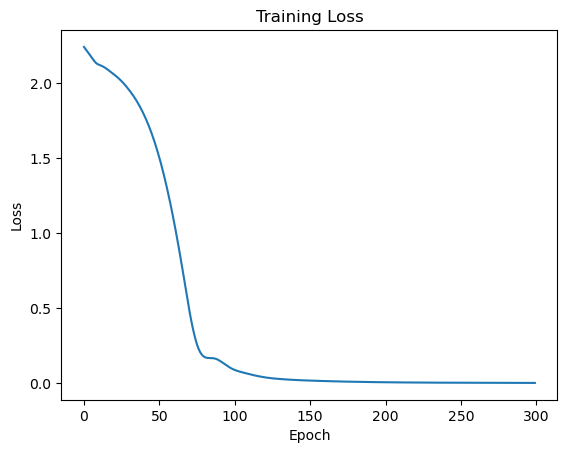

In [39]:
nb_epochs = 300
losses = []
# Before training
#set_seed(42)
model.train()
for i in range(nb_epochs):
    """for X_batch, Y_batch in loader:
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()"""
    

    # Physics loss
    res = pde_residual(model, X_tensor)
    loss_physics = torch.mean(res**2)

    # MSE loss
    outputs = model(X_tensor)
    loss_mse = criterion(outputs, Y_tensor) 

    # final loss
    loss = loss_mse + loss_physics

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())


    print(f'Epoch [{i+ 1}], Loss: {loss.item():.9f}')

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
   

In [40]:
model.eval()

# No gradient calculation during evaluation
with torch.no_grad():
    # Forward pass
    predictions = model(X_tensor)  # Assuming X_tensor is your input data

    # Calculate the loss (optional)
    loss = criterion(predictions, Y_tensor)
    print(f"Evaluation Loss: {loss.item():.3f}")

    predictions_original = scaler_y.inverse_transform(predictions.numpy())

    # Print the inverse transformed predictions
    print("Inverse Predictions: \n", predictions_original)

Evaluation Loss: 0.001
Inverse Predictions: 
 [[ 0.16446476]
 [ 0.57336074]
 [ 1.1138866 ]
 ...
 [ 9.1124325 ]
 [ 9.612331  ]
 [10.11223   ]]


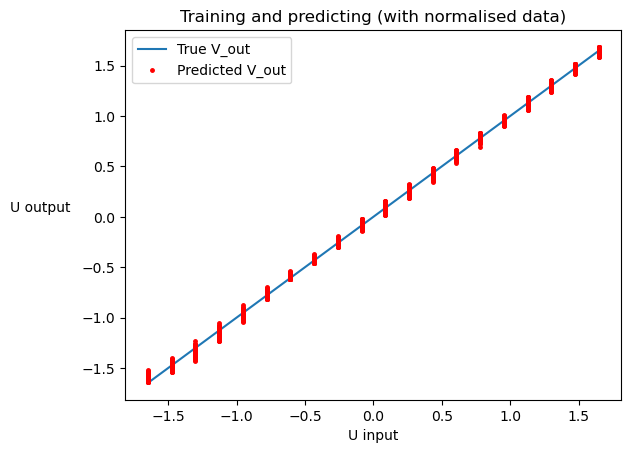

In [41]:
plt.title("Training and predicting (with normalised data)")
plt.plot(X_tensor[:,2], Y_tensor[:,0], label = "True V_out")
plt.xlabel("U input")
plt.ylabel("U output", rotation = 0, labelpad=30)
plt.plot(X_tensor[:,2], predictions[:,0], label = "Predicted V_out", color='red', linestyle='None', marker='.', markersize=5)
plt.legend()


plt.show()